In [32]:

%reload_ext autoreload
%autoreload 2

from func import *
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler



In [33]:
filename = 'all_data_anonymized.csv'
date_col = 'todate'
start_date = '1980-01-01'
seperator = ';'
fill = 0
lim = 5
df_read = load_and_preprocess_data(filename, date_col, start_date, seperator, fill, lim)


d:\master3\Master-thesis\Files\func.py:26: DtypeWarning: Columns (15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_read = pd.read_csv(filename, sep=seperator)


In [34]:
#windows_d = [5, 10, 20, 40, 60, 100, 180, 240, 360, 480]
window_m = [10, 30, 60, 100, 180]
assets = df_read.columns
df_feat = add_features(df_read, window_m)

In [45]:
target_days = 10

cross = False
return_column_shift = 'avgreturn'
volatility_column_shift = 'volatility'
df = add_y_col(df_feat, df_read, date_col, target_days, return_column_shift, volatility_column_shift, cross)

In [131]:
X_train, X_eval, X_test_full, y_train, y_eval, y_test_full, X_train_eval, y_train_eval = prepare_training_dataset(df, date_col, shuffle=False, train_split=0.25, eval_split=0.25)

In [132]:
holding_period = 10

# Initialize the portfolios
all_portfolios = {
    'lgb': pd.DataFrame(),
    'ridge': pd.DataFrame(),
    'NN': pd.DataFrame(),
    'benchmark': pd.DataFrame(),
}

# Initialize model storage dictionary
model_storage = {
    'lgb': {},
    'ridge': {},
    'NN': {},
    'benchmark': {},
}

df_2_read_storage = {}
signals_dfs_storage = {}
portfolio_dfs_storage = {}
X_test_storage = {}

last_two_rows = None


# Initial training and testing periods
end_train_date = df.loc[X_eval.index.max(), 'todate']
end_test_date = df.loc[X_eval.index.max(), 'todate'] + pd.DateOffset(years=holding_period)
start_train_idx = df.index.min()
end_train_idx = X_eval.index.max()

if end_test_date not in df[date_col]:
    end_test_idx = df.index[df[date_col] <= end_test_date].max()
else:
    end_test_idx = df.index.get_loc(end_test_date)

end_test_date_set_to_max = False

print(f"Initial training period: {start_train_idx} to {end_train_idx}")
print(f"Initial testing period: {end_train_idx + 1} to {end_test_idx}")


# Define model parameters and training functions here

while pd.to_datetime(end_test_date) <= df['todate'].max():
    # Slice the training and test datasets based on the dates
    X_test = X_test_full.loc[end_train_idx + 1:end_test_idx]
    y_test = y_test_full.loc[end_train_idx + 1:end_test_idx]
    print(f"New training period: {start_train_idx} to {end_train_idx}")

    # Check if X_test and y_test are not empty
    if X_test.empty or y_test.empty:
        break

    # Define model parameters
    param_grid_NN = {
        'optimizer': ['adam', 'rmsprop'],
        'epochs': [50],
        'batch_size': [64]
    }

    #NN_model, best_params, X_test_scaled = optimize_and_train_NN(X_train, y_train, X_eval, y_eval, X_test, param_grid_NN, cross)

    param_grid_alpha = {'alpha': [0.1, 1.0, 10.0]}

    #ridge_best, grid_search = optimize_and_train_ridge(X_train, y_train, X_eval, y_eval, param_grid_alpha, cross)

    param_grid_lgb = {
        'max_depth': [3, 6, 10],
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 63, 127, 255]
    }

    #lgb_best, best_params = optimize_and_train_lgb(X_train, y_train, X_eval, y_eval, param_grid_lgb, cross)

    # Store models in the dictionary
    #model_storage['lgb'][end_train_date] = lgb_best
    #model_storage['ridge'][end_train_date] = ridge_best
    #model_storage['NN'][end_train_date] = NN_model
    model_storage['benchmark'][end_train_date] = None

    if last_two_rows is not None:
        print('hej')
        start_test_date = df.loc[X_test.index.min(), date_col] - pd.DateOffset(days=2)
        end_test_date_actual = df.loc[X_test.index.max(), date_col]
        df_2 = df.loc[(df[date_col] >= start_test_date) & (df[date_col] <= end_test_date_actual)]
        display(df_2.head())
        df_2_read = df_read.loc[df_2[date_col].unique()]
        df_2_read.fillna(0, inplace=True)
        df_2_read_storage[end_train_date] = df_2_read

        df_2_neutral = df_2_read.copy()
        df_2_neutral.loc[:, :] = 0

    else:

        # Store df_2_read and associated data
        df_2 = df.loc[X_test.index]
        df_2_read = df_read.loc[df_2[date_col].unique()]
        df_2_read.fillna(0, inplace=True)
        df_2_read_storage[end_train_date] = df_2_read

        df_2_neutral = df_2_read.copy()
        df_2_neutral.loc[:, :] = 0

    signals_dfs_storage[end_train_date] = {
        'lgb': df_2_neutral.copy(),
        'ridge': df_2_neutral.copy(),
        'NN': df_2_neutral.copy(),
        'benchmark': df_2_neutral.copy()
    }

    portfolio_dfs_storage[end_train_date] = {
        'lgb': df_2_neutral.copy(),
        'ridge': df_2_neutral.copy(),
        'NN': df_2_neutral.copy(),
        'benchmark': df_2_neutral.copy()
    }
    X_test_storage[end_train_date] = X_test

    if end_train_date in signals_dfs_storage and end_train_date in signals_dfs_storage:
        last_two_rows = signals_dfs_storage[end_train_date]['benchmark'].iloc[-2:]


    end_train_date = end_test_date
    end_test_date = pd.to_datetime(end_test_date) + pd.DateOffset(years=holding_period)
    if pd.to_datetime(end_test_date) > df['todate'].max():
        if not end_test_date_set_to_max:
            print("Reached the end of available data in first iteration.")
            end_test_date = df['todate'].max()
            end_test_date_set_to_max = True
            if end_test_date not in df[date_col]:
                end_test_idx = df.index[df[date_col] <= end_test_date].max()
            else:
                end_test_idx = df.index.get_loc(end_test_date)
            print(f"Updated end_test_idx to last date: {end_test_idx}")  
        else:
            print("Reached the end of available data.")
            break

    

    X_combined = pd.concat([X_train, X_eval, X_test])
    y_combined = pd.concat([y_train, y_eval, y_test])

    split_idx = len(X_combined) // 2

    # Update X_train and X_eval with the first and second halves of the combined data
    X_train = X_combined.iloc[:split_idx]
    X_eval = X_combined.iloc[split_idx:]

    # Update y_train and y_eval similarly
    y_train = y_combined.iloc[:split_idx]
    y_eval = y_combined.iloc[split_idx:]

    # Update start and end indices
    start_train_idx = X_train.index.min()
    end_train_idx = X_eval.index.max()
    if end_test_date not in df[date_col]:
        end_test_idx = df.index[df[date_col] <= end_test_date].max()
    else:
        end_test_idx = df.index.get_loc(end_test_date)

    last_two_rows = "not None"


Initial training period: 120225 to 319039
Initial testing period: 319040 to 470252
New training period: 120225 to 319039
Reached the end of available data in first iteration.
Updated end_test_idx to last date: 516352
New training period: 120225 to 470252
hej


,todate,asset,VaR_10,VaR_100,VaR_180,VaR_30,VaR_60,avgreturn_100,avgreturn_180,avgreturn_30,avgreturn_60,momentum_10,momentum_100,momentum_180,momentum_30,momentum_60,skew_10,skew_100,skew_180,skew_30,skew_60,volatility_100,volatility_180,volatility_30,volatility_60,MACRO_8,MACRO_0,MACRO_1,MACRO_2,MACRO_3,MACRO_4,MACRO_5,MACRO_6,MACRO_7,Y
470137,2021-01-04,EQS_0,-0.012070,-0.019733,-0.026130,-0.013371,-0.018743,0.001579,0.001752,0.002563,0.002524,0.025081,0.153130,0.306650,0.071755,0.146400,-0.325441,1.257722,-0.058515,0.586609,1.662730,0.015365,0.019137,0.011945,0.016734,0.0165,0.027173,-0.018618,-0.023697,0.026908,-0.01971,0.01811,-0.01639,0.002302,0
470138,2021-01-04,EQS_1,-0.009015,-0.016529,-0.016560,-0.007115,-0.012202,0.000629,0.000735,0.001412,0.000756,0.002110,0.061040,0.128674,0.039536,0.043831,0.128987,0.280866,-0.617046,0.130419,0.582963,0.010891,0.011561,0.006324,0.010579,0.0165,0.027173,-0.018618,-0.023697,0.026908,-0.01971,0.01811,-0.01639,0.002302,1
470139,2021-01-04,EQS_10,-0.014100,-0.021125,-0.021130,-0.010107,-0.017504,0.001108,0.001811,0.001389,0.001684,-0.009471,0.106351,0.313307,0.038899,0.096013,0.249030,-0.176889,-0.394738,0.322855,-0.031078,0.014076,0.014334,0.008769,0.013248,0.0165,0.027173,-0.018618,-0.023697,0.026908,-0.01971,0.01811,-0.01639,0.002302,0
470140,2021-01-04,EQS_2,-0.008818,-0.021946,-0.022753,-0.012179,-0.016792,0.001463,0.002155,0.001086,0.001335,-0.003957,0.141892,0.377140,0.030403,0.077415,0.588867,-0.045545,-0.857803,0.590099,0.445607,0.014098,0.015661,0.010286,0.013394,0.0165,0.027173,-0.018618,-0.023697,0.026908,-0.01971,0.01811,-0.01639,0.002302,1
470141,2021-01-04,EQS_3,-0.017952,-0.022947,-0.025289,-0.012297,-0.022811,0.001176,0.001998,-0.000034,0.001221,-0.024457,0.114048,0.349626,-0.000955,0.070829,-1.648630,-0.238324,-0.279409,-0.336566,0.053547,0.013266,0.016642,0.009370,0.013479,0.0165,0.027173,-0.018618,-0.023697,0.026908,-0.01971,0.01811,-0.01639,0.002302,1


Reached the end of available data.


In [134]:
for name, model_dict in model_storage.items():
    k = 0
    for train_date, model in model_dict.items():
        X_test = X_test_storage[train_date]
        df_2_read = df_2_read_storage[train_date]

        signals_dfs = signals_dfs_storage[train_date]
        portfolio_dfs = portfolio_dfs_storage[train_date]
        print(f"Training and testing {name} models for {train_date}")
        best_assets, worst_assets = predict_and_analyze_ext(model, X_test, df, name, df_read, date_col, cross, top_percentile=70, bottom_percentile=30)
    
        assets_df = pd.concat([best_assets, worst_assets])
        assets_df['update_value'] = 0
        assets_df.loc[assets_df[name] > assets_df['top_threshold'], 'update_value'] = 1
        assets_df.loc[assets_df[name] < assets_df['bottom_threshold'], 'update_value'] = -1

        pivot_df = assets_df.pivot_table(index='todate', columns='asset', values='update_value', fill_value=0)
        signals_dfs[name].update(pivot_df)

        portfolio_dfs[name] = update_df_with_asset_performance(signals_dfs[name], portfolio_dfs[name], target_days, df_read)
        if k == 0:
            all_portfolios[name] = pd.concat([all_portfolios[name], portfolio_dfs[name]])
        else:
            all_portfolios[name] = pd.concat([all_portfolios[name], portfolio_dfs[name].iloc[2:]])
        k += 1
                

Training and testing benchmark models for 2011-01-05 00:00:00
Training and testing benchmark models for 2021-01-05 00:00:00


In [135]:
"""for name, sig_dict in signals_dfs_storage:
    for train_date, signals_df in sig_dict.items():
        # concat the signals_df with the benchmark signals_df
        signal_bench_rolling = pd.concat([signals_df, signals_dfs_storage[train_date]['benchmark']])
"""

len(all_portfolios['benchmark'])
#portf_bench_rolling = pd.concat([signals_dfs_storage[pd.Timestamp('2011-01-05 00:00:00')]['benchmark'], signals_dfs_storage[pd.Timestamp('2021-01-05 00:00:00')]['benchmark']])

3359

In [139]:
# import signal_bench pickle and open it
portf_bench_non_roll = pickle.load(open('portfolio_bench.pickle', 'rb'))
    


In [140]:
# compare signal_bench_rolling with signal_bench_non_roll

# compare the two signals
diff = all_portfolios['benchmark'].compare(portf_bench_non_roll)


In [142]:
diff.head(15)

EQ_0            EQ_1           EQ_2            EQ_3            \
           self other      self     other self other      self     other   
todate                                                                     
2021-01-06  NaN   NaN  0.066264  0.033806  NaN   NaN       NaN       NaN   
2021-01-07  NaN   NaN  0.066264  0.075232  NaN   NaN       NaN       NaN   
2021-01-08  NaN   NaN  0.066264  0.075232  NaN   NaN       NaN       NaN   
2021-01-11  NaN   NaN  0.066264  0.075232  NaN   NaN       NaN       NaN   
2021-01-12  NaN   NaN  0.066264  0.075232  NaN   NaN       NaN       NaN   
2021-01-13  NaN   NaN  0.066264  0.075232  NaN   NaN       NaN       NaN   
2021-01-14  NaN   NaN  0.066264  0.075232  NaN   NaN       NaN       NaN   
2021-01-15  NaN   NaN  0.066264  0.075232  NaN   NaN       NaN       NaN   
2021-01-18  NaN   NaN  0.066264  0.075232  NaN   NaN       NaN       NaN   
2021-01-19  NaN   NaN  0.066264  0.075232  NaN   NaN       NaN       NaN   
2021-01-20  NaN   NaN  0.029330  0.075232  NaN   NaN  0.026453  0.000000   
2021-01-21  NaN   NaN  0.029330  0.030147  NaN   NaN  0.026453  0.027056   
2021-01-22  NaN   NaN  0.029330  0.030147  NaN   NaN  0.026453  0.027056   
2021-01-25  NaN   NaN  0.029330  0.030147  NaN   NaN  0.026453  0.027056   
2021-01-26  NaN   NaN  0.029330  0.030147  NaN   NaN  0.026453  0.027056   

                EQ_4                EQ_5                EQ_6           EQ_7  \
                self     other      self     other      self     other self   
todate                                                                        
2021-01-06  0.061130  0.032158  0.052652  0.027646  0.083471  0.041607  NaN   
2021-01-07  0.061130  0.069599  0.052652  0.059777  0.083471  0.096172  NaN   
2021-01-08  0.061130  0.069599  0.052652  0.059777  0.083471  0.096172  NaN   
2021-01-11  0.061130  0.069599  0.052652  0.059777  0.083471  0.096172  NaN   
2021-01-12  0.061130  0.069599  0.052652  0.059777  0.083471  0.096172  NaN   
2021-01-13  0.061130  0.069599  0.052652  0.059777  0.083471  0.096172  NaN   
2021-01-14  0.061130  0.069599  0.052652  0.059777  0.083471  0.096172  NaN   
2021-01-15  0.061130  0.069599  0.052652  0.059777  0.083471  0.096172  NaN   
2021-01-18  0.061130  0.069599  0.052652  0.059777  0.083471  0.096172  NaN   
2021-01-19  0.061130  0.069599  0.052652  0.059777  0.083471  0.096172  NaN   
2021-01-20  0.026591  0.069599  0.022629  0.059777  0.038179  0.096172  NaN   
2021-01-21  0.026591  0.027195  0.022629  0.023168  0.038179  0.039954  0.0   
2021-01-22  0.026591  0.027195  0.022629  0.023168  0.038179  0.039954  0.0   
2021-01-25  0.026591  0.027195  0.022629  0.023168  0.038179  0.039954  0.0   
2021-01-26  0.026591  0.027195  0.022629  0.023168  0.038179  0.039954  0.0   

                          EQ_8           EQ_9       EQ_10           EQ_11  \
               other      self     other self other  self other      self   
todate                                                                      
2021-01-06       NaN  0.043960  0.023250  NaN   NaN   NaN   NaN  0.072162   
2021-01-07       NaN  0.043960  0.050139  NaN   NaN   NaN   NaN  0.072162   
2021-01-08       NaN  0.043960  0.050139  NaN   NaN   NaN   NaN  0.072162   
2021-01-11       NaN  0.043960  0.050139  NaN   NaN   NaN   NaN  0.072162   
2021-01-12       NaN  0.043960  0.050139  NaN   NaN   NaN   NaN  0.072162   
2021-01-13       NaN  0.043960  0.050139  NaN   NaN   NaN   NaN  0.072162   
2021-01-14       NaN  0.043960  0.050139  NaN   NaN   NaN   NaN  0.072162   
2021-01-15       NaN  0.043960  0.050139  NaN   NaN   NaN   NaN  0.072162   
2021-01-18       NaN  0.043960  0.050139  NaN   NaN   NaN   NaN  0.072162   
2021-01-19       NaN  0.043960  0.050139  NaN   NaN   NaN   NaN  0.072162   
2021-01-20       NaN  0.019771  0.050139  NaN   NaN   NaN   NaN  0.030942   
2021-01-21  0.026741  0.019771  0.020397  NaN   NaN   NaN   NaN  0.030942   
2021-01-22  0.026741  0.019771  0.020397  NaN   NaN   NaN   NaN 

In [61]:
# Store predictions in a dictionary
"""predictions = {
    "Ridge Classifier": ridge_best.predict(X_test),
    "LightGBM Classifier": lgb_best.predict(X_test),
    "Neural Network": NN_model.predict(X_test_scaled)
}   

# Iterate through the dictionary and evaluate each model
for model_name, y_pred in predictions.items():
    print(model_name + ":")
    if model_name == "Neural Network":
        y_pred = (y_pred > 0.5).astype(int)
    evaluate_model_performance(y_test, y_pred)
    print("\n")
"""

'predictions = {\n    "Ridge Classifier": ridge_best.predict(X_test),\n    "LightGBM Classifier": lgb_best.predict(X_test),\n    "Neural Network": NN_model.predict(X_test_scaled)\n}   \n\n# Iterate through the dictionary and evaluate each model\nfor model_name, y_pred in predictions.items():\n    print(model_name + ":")\n    if model_name == "Neural Network":\n        y_pred = (y_pred > 0.5).astype(int)\n    evaluate_model_performance(y_test, y_pred)\n    print("\n")\n'

In [136]:
# keep same index from X_test in df as new df

df_2 = df.loc[X_test_full.index]
# Use the dates in df_2 to filter rows in df_read
df_2_read = df_read.loc[df_2[date_col].unique()]

# fill missing values with 0
df_2_read.fillna(0, inplace=True)

In [137]:
lgb_weights = all_portfolios['lgb']
ridge_weights = all_portfolios['ridge']
NN_weights = all_portfolios['NN']
benchmark_weights = all_portfolios['benchmark']




lgb_returns = lgb_weights*df_2_read
ridge_returns = ridge_weights*df_2_read
NN_returns = NN_weights*df_2_read
benchmark_returns = benchmark_weights*df_2_read


"""
lgb_trade_volume = calculate_trade_volume(lgb_weights)
ridge_trade_volume = calculate_trade_volume(ridge_weights)
NN_trade_volume = calculate_trade_volume(NN_weights)"""

'\nlgb_trade_volume = calculate_trade_volume(lgb_weights)\nridge_trade_volume = calculate_trade_volume(ridge_weights)\nNN_trade_volume = calculate_trade_volume(NN_weights)'

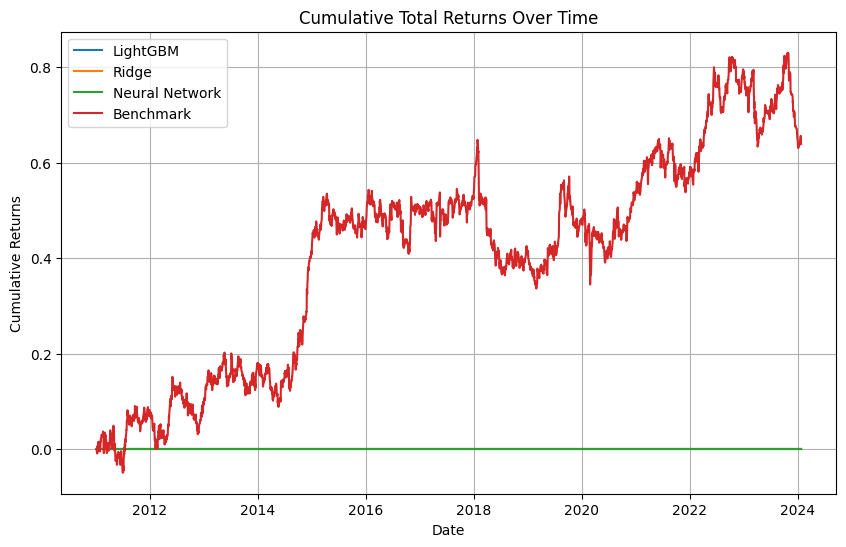

In [138]:
import matplotlib.pyplot as plt

# Sum the returns across all assets for each day to get the daily total returns for each model
lgb_total_returns = lgb_returns.sum(axis=1)
ridge_total_returns = ridge_returns.sum(axis=1)
NN_total_returns = NN_returns.sum(axis=1)
benchmark_total_returns = benchmark_returns.sum(axis=1)

lgb_cumulative_total_returns = lgb_total_returns.cumsum()
ridge_cumulative_total_returns = ridge_total_returns.cumsum()
NN_cumulative_total_returns = NN_total_returns.cumsum()
benchmark_cumulative_total_returns = benchmark_total_returns.cumsum()

# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(lgb_cumulative_total_returns, label='LightGBM')
plt.plot(ridge_cumulative_total_returns, label='Ridge')
plt.plot(NN_cumulative_total_returns, label='Neural Network')
plt.plot(benchmark_cumulative_total_returns, label='Benchmark')
plt.title('Cumulative Total Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()



In [65]:
%reload_ext autoreload
%autoreload 2
#ridge_metrics = financial_metrics(ridge_total_returns, ridge_weights)
#lgb_metrics = financial_metrics(lgb_total_returns, lgb_weights)
#NN_metrics = financial_metrics(NN_total_returns,NN_weights )
benchmark_metrics = financial_metrics(benchmark_total_returns, benchmark_weights)
metrics = {
#    "Ridge": ridge_metrics,
#    "LightGBM": lgb_metrics,
#    "Neural Network": NN_metrics,
    "Benchmark": benchmark_metrics
}

metrics_df = pd.DataFrame(metrics).T  


In [66]:
metrics_df

,Average Yearly Return,Average Yearly Standard Deviation,Calmar Ratio,Kurtosis,Max Drawdown,Skewness,Yearly Sharpe Ratio,Yearly Trades,Yearly Transaction Costs,Yearly Turnover,Yearly Volatility
Benchmark,0.056412,0.127753,0.210875,6.087309,-0.267515,-0.582274,0.441573,925.357143,0.006858,68.579299,0.127753


In [67]:
ridge_turnover = ridge_weights.diff().abs().sum(axis=1)
lgb_turnover = lgb_weights.diff().abs().sum(axis=1)
NN_turnover = NN_weights.diff().abs().sum(axis=1)
bench_turnover = benchmark_weights.diff().abs().sum(axis=1)


ridge_trans_cost = ridge_turnover * 0.01 *0.01
lgb_trans_cost = lgb_turnover * 0.01 * 0.01
NN_trans_cost = NN_turnover * 0.01 * 0.01
bench_trans_cost = bench_turnover * 0.01 * 0.01

ridge_adjusted_returns = ridge_total_returns - ridge_trans_cost
lgb_adjusted_returns = lgb_total_returns - lgb_trans_cost
NN_adjusted_returns = NN_total_returns - lgb_trans_cost
bench_adjusted_returns = benchmark_total_returns - bench_trans_cost

ridge_cumulative_total_returns_post_cost = ridge_adjusted_returns.cumsum()
lgb_cumulative_total_returns_post_cost = lgb_adjusted_returns.cumsum()
NN_cumulative_total_returns_post_cost = NN_adjusted_returns.cumsum()
bench_cumulative_total_returns_post_cost = bench_adjusted_returns.cumsum()



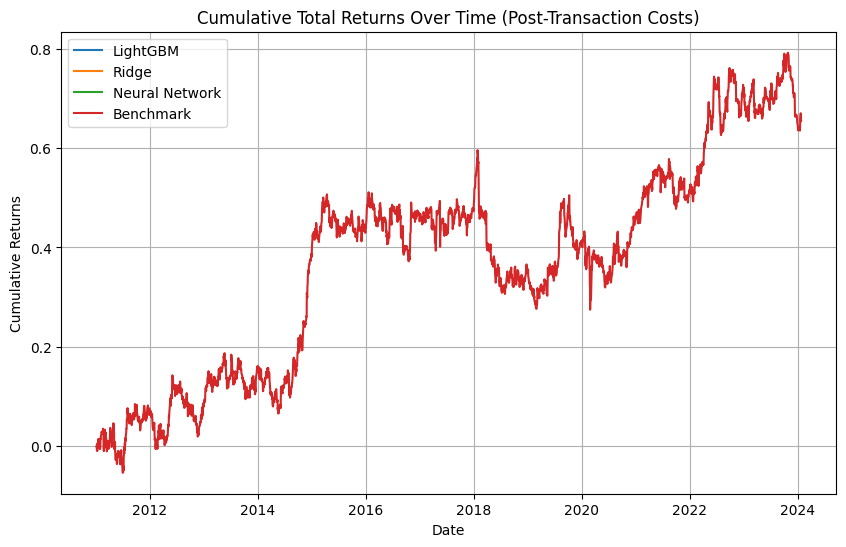

In [68]:



# Plot the cumulative total returns for each model
plt.figure(figsize=(10, 6))
plt.plot(lgb_cumulative_total_returns_post_cost, label='LightGBM')
plt.plot(ridge_cumulative_total_returns_post_cost, label='Ridge')
plt.plot(NN_cumulative_total_returns_post_cost, label='Neural Network')
plt.plot(bench_cumulative_total_returns_post_cost, label='Benchmark')
plt.title('Cumulative Total Returns Over Time (Post-Transaction Costs)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

